## Word Representation (Skip Gram Model)

ここでのSkip Gramモデルの主要部分は以下の通りです。

    model = Sequential()  
    model.add(Dense(300, input_shape=(10000,)))  
    model.add(Activation("relu"))  
    model.add(Dropout(0.5))  
    model.add(Dense(10000))  
    model.add(Activation("softmax"))  
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  
このモデルをトレーニングした後に, 入力層と隠れ層の間の重みを取出す.

    W, b = model.layers[0].get_weights()
    
これを用いて単語を入力して, 層のベクトルがどうなるかを観察すれば入力語の分散表現になる。

In [22]:
%matplotlib inline
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import nltk
import numpy as np
#import operator
import codecs

np.random.seed(42)

BATCH_SIZE = 128
NUM_EPOCHS = 20

## トレーニングデータの作成

ターゲットとする単語をxsとして, その周囲の単語をysとしてトレーニングデータを作る.
nltkを利用すると同じパターンを処理する必要がないので、全体の速度を向上できる.
3グラムとは文章中に3単語がその順序で登場することを指す. つまり,
’she took the’という文字列が表われれば, これが3グラムとなる.


In [23]:
infile = codecs.open("./alice_in_wonderland.txt", "r", 'utf-8')
text = infile.read()
sents = nltk.sent_tokenize(text)
tokenizer = Tokenizer(5000)  
tokens = tokenizer.fit_on_texts(sents)
vocab_size = len(tokenizer.word_counts) + 1
print ('vocab_size=', vocab_size)
xs = []
ys = []
for sent in sents:
    embedding = one_hot(sent, vocab_size)
    triples = list(nltk.trigrams(embedding))
    for x in triples:
        left_word = x[0]
        center_word = x[1]
        right_word = x[2]
        xs.append(center_word)
        ys.append(left_word)
        xs.append(center_word)
        ys.append(right_word)

xs=np.array(xs).reshape(-1,1)
ys=np.array(ys).reshape(-1,1)
ohe = OneHotEncoder()
ohe2 = OneHotEncoder()
X = ohe.fit_transform(xs).todense()
print (ohe.fit_transform(np.array(1).reshape(-1,1)))
Y = ohe2.fit_transform(ys).todense()
print (X)
Xtrain0, Xtest, Ytrain0, Ytest = train_test_split(X, Y, test_size=0.3, random_state=42)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain0, Ytrain0, test_size=0.3, random_state=42)

vocab_size= 2647
  (0, 0)	1.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## モデルのbuild

In [24]:
print(Xtrain.shape, Xtest.shape, Xval.shape, Ytrain.shape, Ytest.shape, Yval.shape)
vocab_input=Xtrain.shape[1]
vocab_output=Ytrain.shape[1]

model = Sequential()
model.add(Dense(300, input_shape=(vocab_input,)))
#model.add(Dense(10, input_shape=(vocab_input,)))
model.add(Activation("relu"))
model.add(Dropout(0.3))
model.add(Dense(vocab_output))
model.add(Activation("softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

(24083, 1654) (14745, 1654) (10322, 1654) (24083, 1697) (14745, 1697) (10322, 1697)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               496500    
_________________________________________________________________
activation_5 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1697)              510797    
_________________________________________________________________
activation_6 (Activation)    (None, 1697)              0         
Total params: 1,007,297
Trainable params: 1,007,297
Non-trainable params: 0
_________________________________________________________________


Train on 24083 samples, validate on 10322 samples
Epoch 1/20
24083/24083 [==============================] - 1s 42us/step - loss: 6.2368 - accuracy: 0.0558 - val_loss: 5.7250 - val_accuracy: 0.0582
Epoch 2/20
24083/24083 [==============================] - 1s 38us/step - loss: 5.6174 - accuracy: 0.0624 - val_loss: 5.6622 - val_accuracy: 0.0662
Epoch 3/20
24083/24083 [==============================] - 1s 40us/step - loss: 5.4869 - accuracy: 0.0769 - val_loss: 5.5928 - val_accuracy: 0.0821
Epoch 4/20
24083/24083 [==============================] - 1s 41us/step - loss: 5.3401 - accuracy: 0.1014 - val_loss: 5.5263 - val_accuracy: 0.1031
Epoch 5/20
24083/24083 [==============================] - 1s 48us/step - loss: 5.1957 - accuracy: 0.1234 - val_loss: 5.4762 - val_accuracy: 0.1101
Epoch 6/20
24083/24083 [==============================] - 1s 44us/step - loss: 5.0599 - accuracy: 0.1352 - val_loss: 5.4455 - val_accuracy: 0.1155
Epoch 7/20
24083/24083 [==============================] - 1s 45us/st

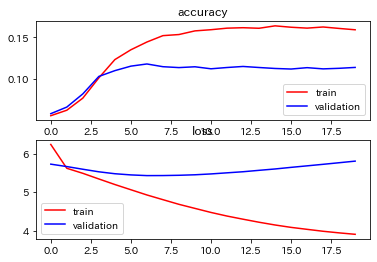

14745/14745 [==============================] - 1s 58us/step
Test score: 5.819, accuracy: 0.116


In [25]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1,
                    validation_data=(Xval, Yval))

print (history.history)
print (history.history['accuracy'])
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")
plt.show()

score = model.evaluate(Xtest, Ytest, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

## 学習したモデルを用いて, 入力に対応する分散表現を得る部分

In [26]:
word2idx = tokenizer.word_index
idx2word = {v: k for k, v in word2idx.items()}
W, b = model.layers[0].get_weights()

idx2emb = {}
for word in word2idx.keys():
    wid = word2idx[word]
    vec_in=X[wid]
    vec_emb = np.dot(vec_in, W)
    idx2emb[wid] = vec_emb


## 得た分散表現をチェックする

たとえば、'the'の分散表現は何になっているか？'alice'は何だろうか？なお, トレーニングデータにない単語は出て来ない.

In [27]:
print (idx2emb[word2idx['the']])
print (idx2emb[word2idx['alice']])
print (idx2emb[word2idx['rabbit']])

[[ 0.21494281 -0.05330862 -0.04754988 -0.10625503 -0.07854003 -0.00062628
   0.18559428  0.16224663  0.3374702  -0.08483033  0.2123654   0.2539317
   0.2724154  -0.21846159  0.27313077 -0.20524786  0.06045305 -0.06676494
  -0.13488717  0.07177778 -0.16947892 -0.19139107  0.06959492 -0.02421925
  -0.15088205  0.13875407  0.15811808 -0.11760682 -0.10078792 -0.15141788
  -0.12081534 -0.07080677 -0.09264085 -0.16889948 -0.17696825 -0.19245595
  -0.04424151 -0.16412896  0.10212614  0.17784508 -0.17801563  0.27379641
   0.27422467 -0.176816   -0.18286614  0.06668326 -0.03775994 -0.15174137
  -0.14806862 -0.05824434 -0.17858872  0.16503574  0.23528138 -0.19820812
  -0.16563809 -0.001779    0.11431494 -0.06246034 -0.05386112  0.46437848
  -0.19882105  0.2443728   0.02946078  0.2596857  -0.07179432 -0.06634992
   0.0305259   0.20801224 -0.17322978  0.05544059 -0.09846037 -0.08952275
   0.23009945  0.03421481 -0.19370715  0.38170761  0.09271056 -0.05973897
  -0.00340015  0.14354764 -0.08476043  